# 📊 Forecasting Kenyan Monthly Inflation Rates (2005–2025)  
Using SARIMA & Facebook Prophet Models



## 📌 1. Project Overview
In this project, we use real **monthly inflation data** from 2005–2025 to build forecasting models:
✅ Seasonal ARIMA (SARIMA)  
✅ Facebook Prophet

We compare models based on:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)


## 📥 2. Load & Preprocess Data


In [ ]:
import sys
sys.path.append('../src')

from data_preprocessing import load_and_preprocess

# Load dataset
df = load_and_preprocess('../data/Inflation Rates.csv')
print(df.head())

            inflation_rate
date                      
2005-01-01           14.87
2005-02-01           13.94
2005-03-01           14.15
2005-04-01           16.02
2005-05-01           14.78


c:\Users\STEVE\OneDrive\Desktop\PYTHON\kenya-inflation-forecast\notebooks\../src\data_preprocessing.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str))


## 📊 3. Exploratory Data Analysis (EDA)
**Visualize trends, rolling stats & test stationarity**.


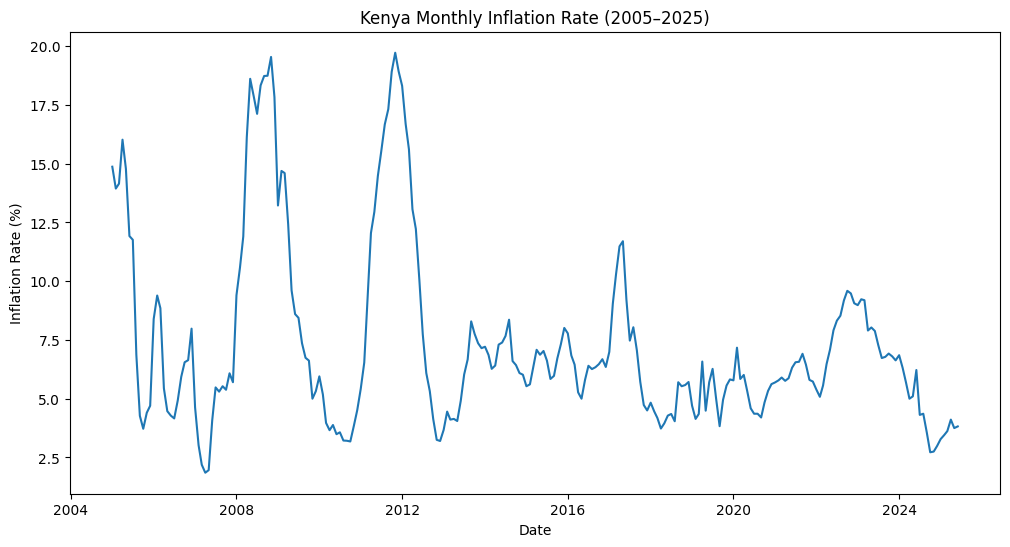

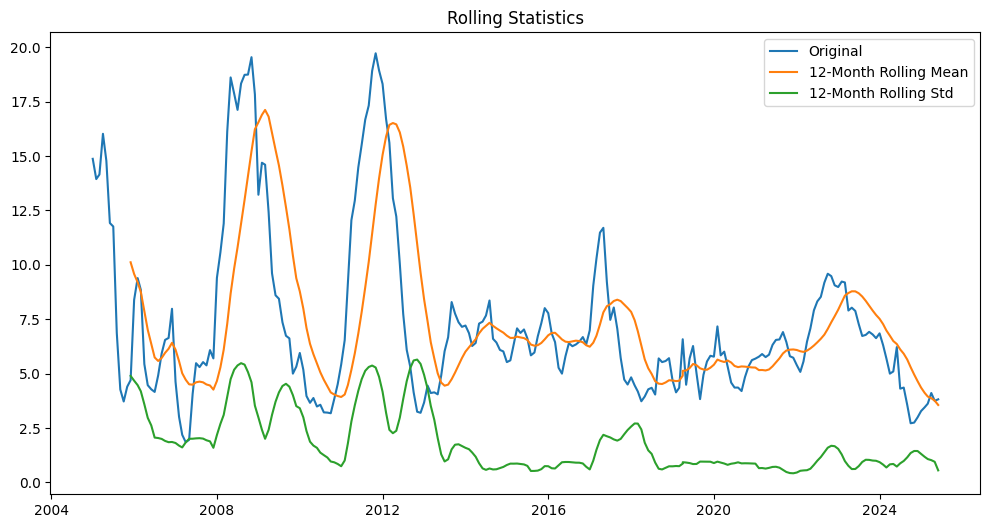

ADF Statistic: -3.4813822512639048
p-value: 0.008478310815055071
Critical Value (1%): -3.459105583381277
Critical Value (5%): -2.8741898504150574
Critical Value (10%): -2.5735117958412097


In [4]:
from eda import plot_inflation_trend, plot_rolling_statistics, adf_test

plot_inflation_trend(df)
plot_rolling_statistics(df, window=12)
adf_test(df)


## 🔧 4. Train-Test Split
**Use data before 2024 for training, and 2024–2025 for testing**.

In [5]:
train = df[:'2023-12-01']
test = df['2024-01-01':]
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (229, 1), Test shape: (18, 1)


## 📉 5. Model 1: SARIMA (Auto ARIMA to select order)

In [6]:
from modeling_arima import auto_arima_order, train_sarima, forecast_sarima

# Find best order
order, seasonal_order = auto_arima_order(train['inflation_rate'], seasonal=True, m=12)

# Train model
sarima_model = train_sarima(train['inflation_rate'], order, seasonal_order)

# Forecast
forecast_arima_mean, forecast_ci = forecast_sarima(sarima_model, steps=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=625.172, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=726.829, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=633.142, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=621.745, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=725.042, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=694.640, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=620.968, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=635.455, Time=0.13 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=622.578, Time=0.65 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=622.639, Time=0.96 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=620.677, Time=0.48 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=643.700, Time=0.44 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=621.819, Time=0.93 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=621.868, Time=0.54 sec
 ARIMA(1,1,0)(0,0,2)[12] intercep

c:\Users\STEVE\OneDrive\Desktop\PYTHON\.venvBayes\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\STEVE\OneDrive\Desktop\PYTHON\.venvBayes\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\STEVE\OneDrive\Desktop\PYTHON\.venvBayes\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\STEVE\OneDrive\Desktop\PYTHON\.venvBayes\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, callin

## 🔮 6. Model 2: Facebook Prophet

In [7]:
from modeling_prophet import prepare_prophet_df, train_prophet, forecast_prophet

# Prepare data
prophet_df = prepare_prophet_df(df)
train_p = prophet_df[prophet_df['ds'] < '2024-01-01']
test_p = prophet_df[prophet_df['ds'] >= '2024-01-01']

# Train
prophet_model = train_prophet(train_p)

# Forecast
forecast_p = forecast_prophet(prophet_model, periods=len(test))
forecasted_prophet = forecast_p[-len(test):]['yhat'].values


17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
prophet_model

In [10]:
forecast_p.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-01,9.495397,4.365832,14.395964,9.495397,9.495397,-0.027370,-0.027370,-0.027370,-0.027370,-0.027370,-0.027370,0.0,0.0,0.0,9.468027
1,2005-02-01,9.478573,4.608860,14.299884,9.478573,9.478573,0.041297,0.041297,0.041297,0.041297,0.041297,0.041297,0.0,0.0,0.0,9.519870
2,2005-03-01,9.463378,4.841835,14.660792,9.463378,9.463378,0.196475,0.196475,0.196475,0.196475,0.196475,0.196475,0.0,0.0,0.0,9.659852
3,2005-04-01,9.446554,5.068078,14.508430,9.446554,9.446554,0.291198,0.291198,0.291198,0.291198,0.291198,0.291198,0.0,0.0,0.0,9.737752
4,2005-05-01,9.430273,5.245973,14.533597,9.430273,9.430273,0.148814,0.148814,0.148814,0.148814,0.148814,0.148814,0.0,0.0,0.0,9.579087


In [11]:
forecasted_prophet

array([5.78685033, 5.95455601, 5.97489482, 6.00828548, 5.84158799,
       5.65453199, 5.64235071, 5.36654086, 5.32262483, 5.37083092,
       5.38167545, 5.33114521, 5.52357969, 5.57565629, 5.71584939,
       5.79398252, 5.63554377, 5.4906519 ])

## 📏 7. Evaluate Models

SARIMA → MAE: 2.50, RMSE: 2.84
Prophet → MAE: 1.52, RMSE: 1.69


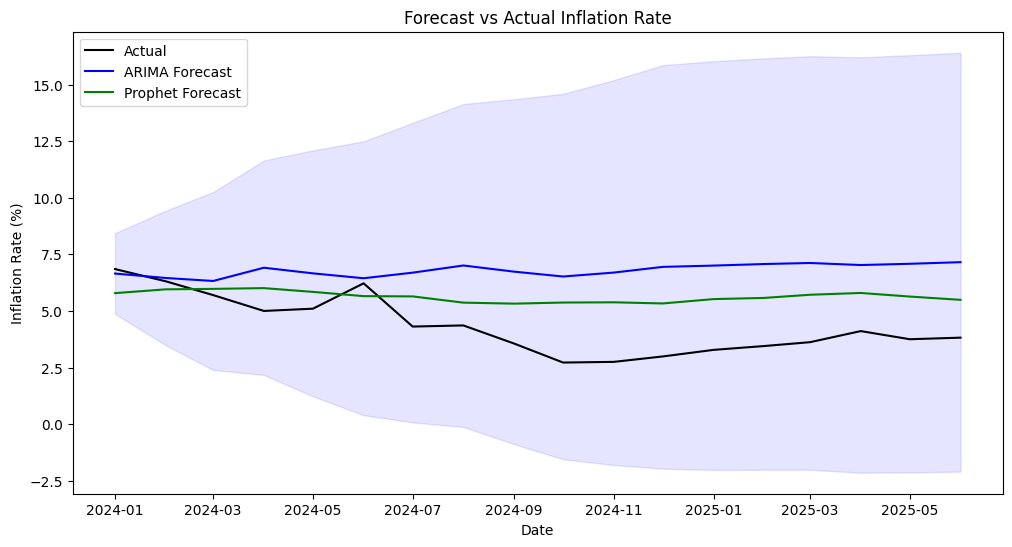

In [12]:
from evaluation import compute_metrics, plot_forecasts

# Compute metrics
mae_arima, rmse_arima = compute_metrics(test['inflation_rate'], forecast_arima_mean)
mae_prophet, rmse_prophet = compute_metrics(test_p['y'], forecasted_prophet)

print(f"SARIMA → MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"Prophet → MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")

# Plot
plot_forecasts(
    test.index, 
    test['inflation_rate'], 
    forecast_arima_mean, 
    forecasted_prophet, 
    ci=forecast_ci
)


## 📝 8. Conclusion & Next Steps
- Both models capture inflation trends; Prophet often handles seasonality robustly.
- Possible improvements:
  - Add external regressors (oil price, FX, etc.)
  - Use cross-validation instead of simple split
  - Deploy as dashboard (Streamlit)

✅ Thank you for exploring this project!